Exploratory Data Analysis Notebook
---

>**How to Read `landmark_id`**
>
>landmark_id structure: {`frame`}-{`landmark_type`}-{`landmark index`}
>
>
>**Example:** `42-left_hand-20`
>
>Frame → 42<br>
>Landmark Type → Left Hand<br>
>Landmark Index → 20

> **Index Range of Landmark Type**
>
> * Face: `0-467`
> * Pose: `468-500`
> * Right Hand: `501-521`
> * Left Hand: `522-542`
>
> Landmark order each frame: **|** [`IDX:0`] Face → Pose → Right Hand → Left Hand [`IDX:542`] **|** [`IDX:543`]

## Import Depedencies

In [1]:
import numpy as np
import tqdm

from matplotlib import pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns

## Function Helper

In [2]:
def get_total_frame(data_PATH):
    numOf_frame_list = []
    
    for i in tqdm.notebook.tnrange(len(data_PATH), desc="Getting Total Frames"):
        numOf_frame_list.append(
            int(pd.read_parquet(data_PATH[i], columns=['landmark_id']).iloc[-1].item().split('-')[0])
        )
    return numOf_frame_list

In [3]:
def get_landmark_dimension(expanded_data, landmark_type):
    ROW_PER_FRAME = 543
    rhIDX = 501
    lhIDX = 522
    poseIDX = 468
    faceIDX = 0
    
    X, Y, Z, VIS = [], [], [], []
    
    for i in tqdm.notebook.tnrange(len(expanded_data.path), desc=f"Obtaining \"{landmark_type}\" Dimension"):
        data = pd.read_parquet(expanded_data.path.iloc[i])
        
        for frame in range(expanded_data.total_frame.iloc[i]):
            boundary = 543 * frame
            
            if landmark_type == 'right_hand':
                X.append(data.x.iloc[rhIDX+boundary : lhIDX+boundary])
                Y.append(data.y.iloc[rhIDX+boundary : lhIDX+boundary])
                Z.append(data.z.iloc[rhIDX+boundary : lhIDX+boundary])
            elif landmark_type == 'left_hand':
                X.append(data.x.iloc[lhIDX+boundary : ROW_PER_FRAME+boundary])
                Y.append(data.y.iloc[lhIDX+boundary : ROW_PER_FRAME+boundary])
                Z.append(data.z.iloc[lhIDX+boundary : ROW_PER_FRAME+boundary])
            elif landmark_type == 'pose':
                X.append(data.x.iloc[poseIDX+boundary : rhIDX+boundary])
                Y.append(data.y.iloc[poseIDX+boundary : rhIDX+boundary])
                Z.append(data.z.iloc[poseIDX+boundary : rhIDX+boundary])
                VIS.append(data.vis.iloc[poseIDX+boundary : rhIDX+boundary])
            elif landmark_type == 'face':
                X.append(data.x.iloc[faceIDX+boundary : poseIDX+boundary])
                Y.append(data.y.iloc[faceIDX+boundary : poseIDX+boundary])
                Z.append(data.z.iloc[faceIDX+boundary : poseIDX+boundary])  
    
    return((np.array(X), np.array(Y), np.array(Z), np.array(VIS)) if landmark_type == 'pose' else (np.array(X), np.array(Y), np.array(Z)))

## Setup and Load Data

In [4]:
df_expanded = pd.read_csv('expanded_data_map.csv')

In [5]:
df_expanded_balanced = df_expanded[df_expanded.sign.isin(['kepala', 'gigi', 'batuk', 'perut', 'demam'])].reset_index()

In [6]:
df_expanded_balanced = pd.concat([
    df_expanded_balanced,
    df_expanded.iloc[df_expanded[(df_expanded.sign == 'obat') & ((df_expanded.total_frame >= 30) & (df_expanded.total_frame <= 35))].index],
    df_expanded.iloc[df_expanded[(df_expanded.sign == 'sakit') & ((df_expanded.total_frame >= 30) & (df_expanded.total_frame <= 38))].index],
    df_expanded.iloc[df_expanded[(df_expanded.sign == 'minum') & ((df_expanded.total_frame >= 31) & (df_expanded.total_frame <= 41))].index],
    df_expanded.iloc[df_expanded[(df_expanded.sign == 'resep') & ((df_expanded.total_frame >= 31) & (df_expanded.total_frame <= 38))].index]
], ignore_index=True)

In [7]:
df_expanded_balanced.sign.value_counts()

sign
obat      120
minum     116
resep     116
gigi      113
kepala    113
sakit     113
batuk     112
perut     111
demam     107
Name: count, dtype: int64

In [8]:
df_expanded_balanced.to_csv('balanced_expanded_data_map.csv', index=False)

## Exploratory Data Analysis (EDA)

In [4]:
df_expanded = pd.read_csv('balanced_expanded_data_map.csv')

In [16]:
total_sign = pd.DataFrame(df_expanded.sign.value_counts().sort_values())

fig = px.bar(y=total_sign.index, x=total_sign['count'].tolist(), color=total_sign.index, text_auto=True)
fig.update_layout(bargap=0.25, height=400, width=800, showlegend=False)
fig.update_layout(xaxis_title='Jumlah Video', yaxis_title='Kata Isyarat')
fig.update_layout(title={
    'text': "Jumlah Video Setiap Kata Bahasa Isyarat",
    'x': 0.5,
    'font': {'size': 20, 'family': 'Arial', 'color': 'black'}
})
fig.show()

In [10]:
import plotly.io as pio
pio.write_image(fig, 'asset/number of videos.png',scale=6, width=1080, height=540)

In [11]:
mean_frames = pd.DataFrame(df_expanded.groupby('sign')['total_frame'].mean().sort_values())

fig = px.bar(y=mean_frames.index, x=mean_frames['total_frame'].tolist(), color=mean_frames.index)
fig.update_layout(bargap=0.25, height=400, width=800, showlegend=False)
fig.update_layout(xaxis_title='Average Frame', yaxis_title='Sign')
fig.update_layout(title={
    'text': "Average Frame Each Sign Language Word",
    'x': 0.5,
    'font': {'size': 20, 'family': 'Arial', 'color': 'black'}
})
fig.show()

In [12]:
pd.DataFrame(df_expanded.total_frame.describe())

,total_frame
count,669.000000
mean,34.164425
std,8.412985
min,14.000000
25%,29.000000
50%,33.000000
75%,38.000000
max,71.000000


In [13]:
fig = px.box(df_expanded, x='total_frame')
fig.update_layout(height=400, width=800)

fig.show()

In [14]:
X,Y,Z = get_landmark_dimension(df_expanded,'face')

fig, ax = plt.subplots(3,1,figsize =(250, 22))
plt.subplots_adjust(hspace=.35)

sns.boxplot(ax=ax[0], data=X, width=.3, showfliers=False)
ax[0].set_title('Face X Dimension', fontsize=14)
ax[0].set_xlabel('Landmark X Index')

sns.boxplot(ax=ax[1], data=Y, width=.3, showfliers=False)
ax[1].set_title('Face Y Dimension', fontsize=14)
ax[1].set_xlabel('Landmark Y Index')

sns.boxplot(ax=ax[2], data=Z, width=.3, showfliers=False)
ax[2].set_title('Face Z Dimension', fontsize=14)
ax[2].set_xlabel('Landmark Z Index')

plt.show()

AttributeError: module 'tqdm' has no attribute 'notebook'

Obtaining "pose" Dimension:   0%|          | 0/1021 [00:00<?, ?it/s]

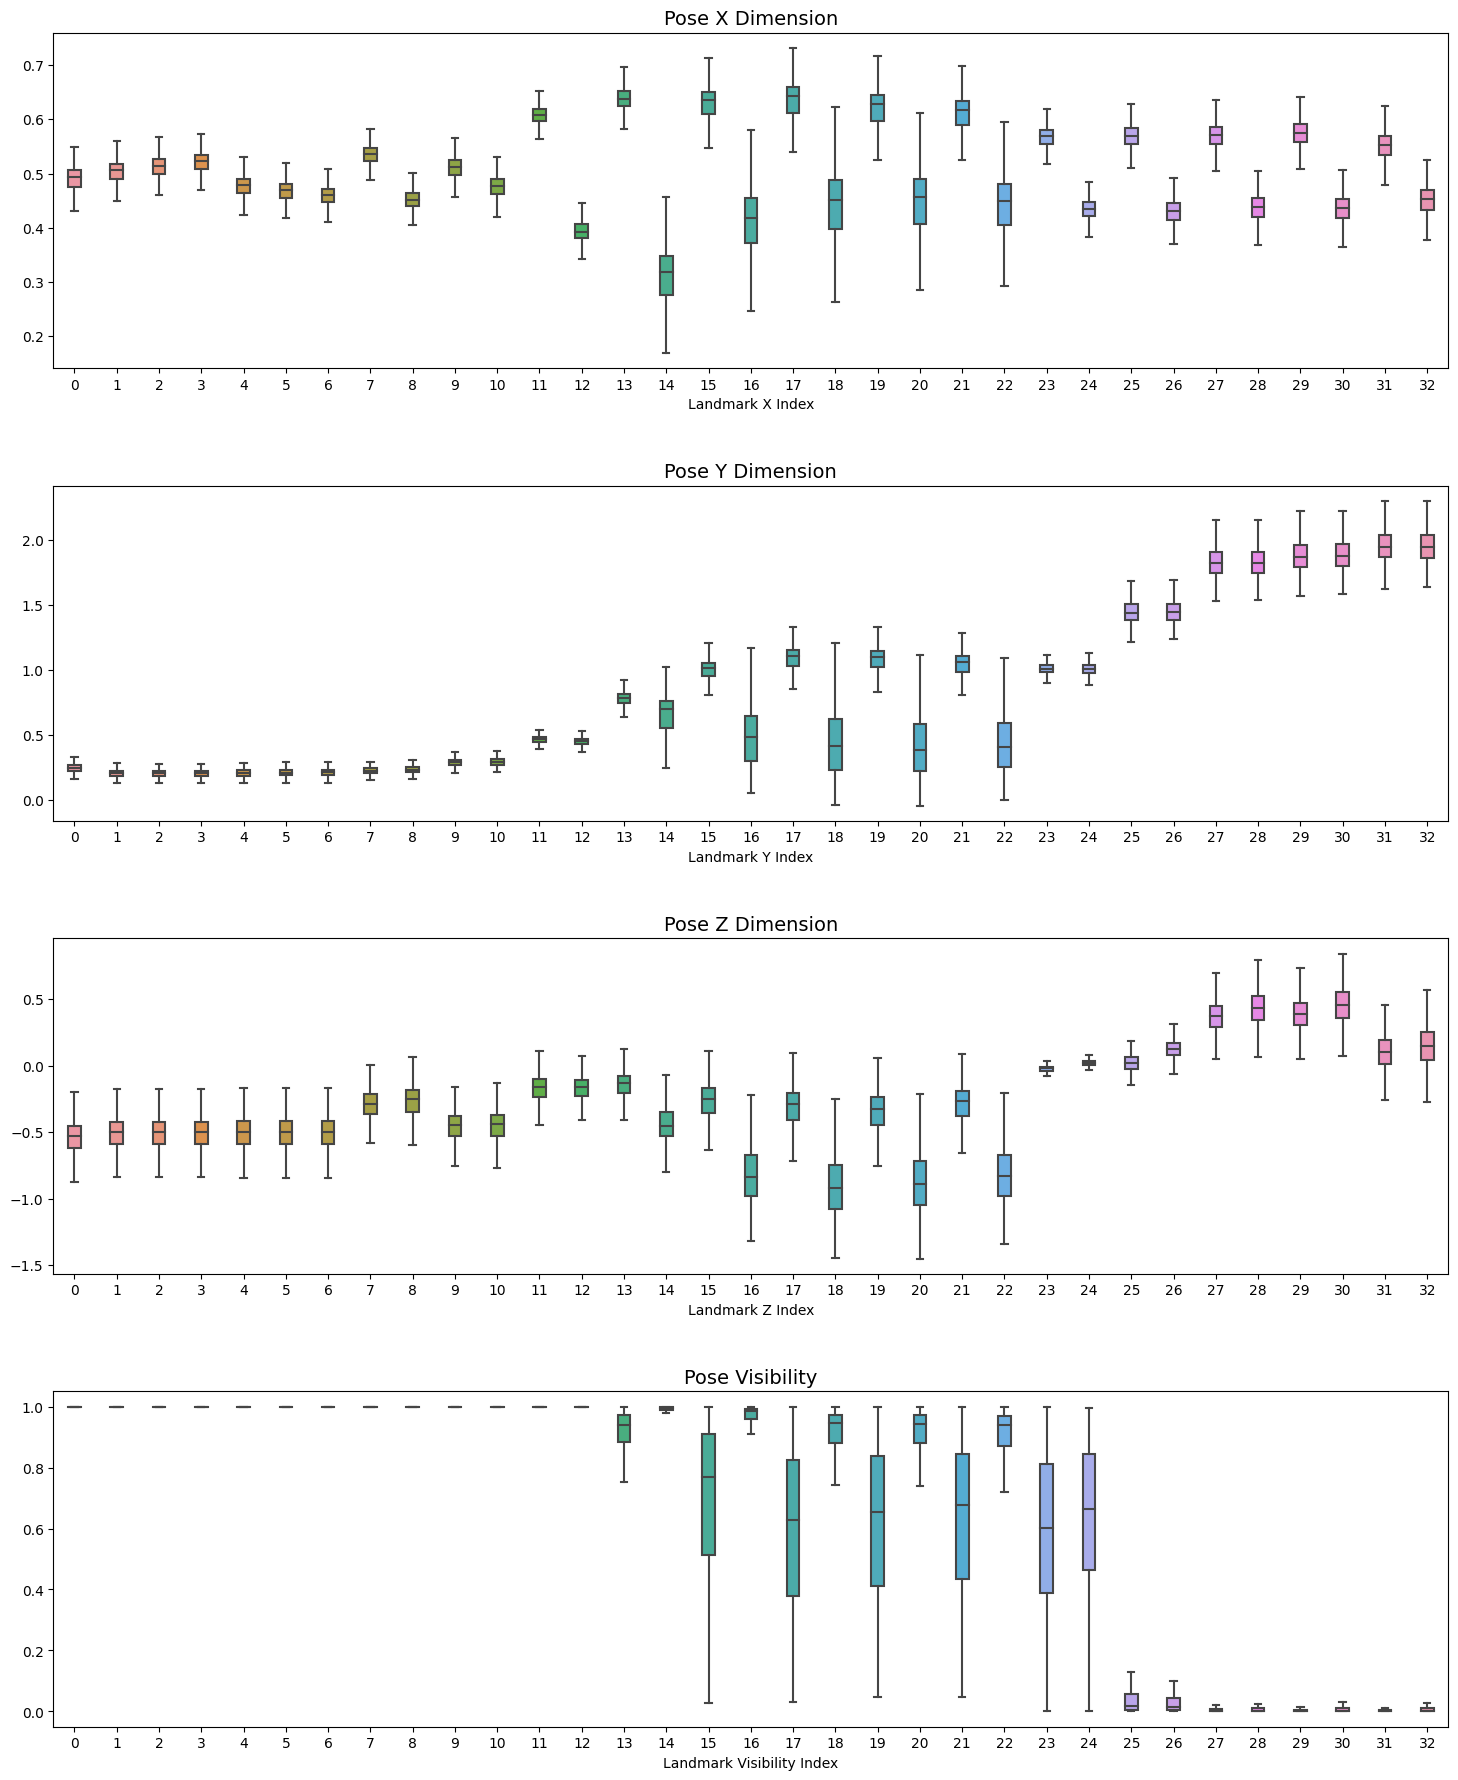

In [12]:
X,Y,Z, VIS = get_landmark_dimension(df_expanded,'pose')

fig, ax = plt.subplots(4,1,figsize =(18, 22))
plt.subplots_adjust(hspace=.35)

sns.boxplot(ax=ax[0], data=X, width=.3, showfliers=False)
ax[0].set_title('Pose X Dimension', fontsize=14)
ax[0].set_xlabel('Landmark X Index')

sns.boxplot(ax=ax[1], data=Y, width=.3, showfliers=False)
ax[1].set_title('Pose Y Dimension', fontsize=14)
ax[1].set_xlabel('Landmark Y Index')

sns.boxplot(ax=ax[2], data=Z, width=.3, showfliers=False)
ax[2].set_title('Pose Z Dimension', fontsize=14)
ax[2].set_xlabel('Landmark Z Index')

sns.boxplot(ax=ax[3], data=VIS, width=.3, showfliers=False)
ax[3].set_title('Pose Visibility', fontsize=14)
ax[3].set_xlabel('Landmark Visibility Index')

plt.show()

Obtaining "right_hand" Dimension:   0%|          | 0/1021 [00:00<?, ?it/s]

Obtaining "left_hand" Dimension:   0%|          | 0/1021 [00:00<?, ?it/s]

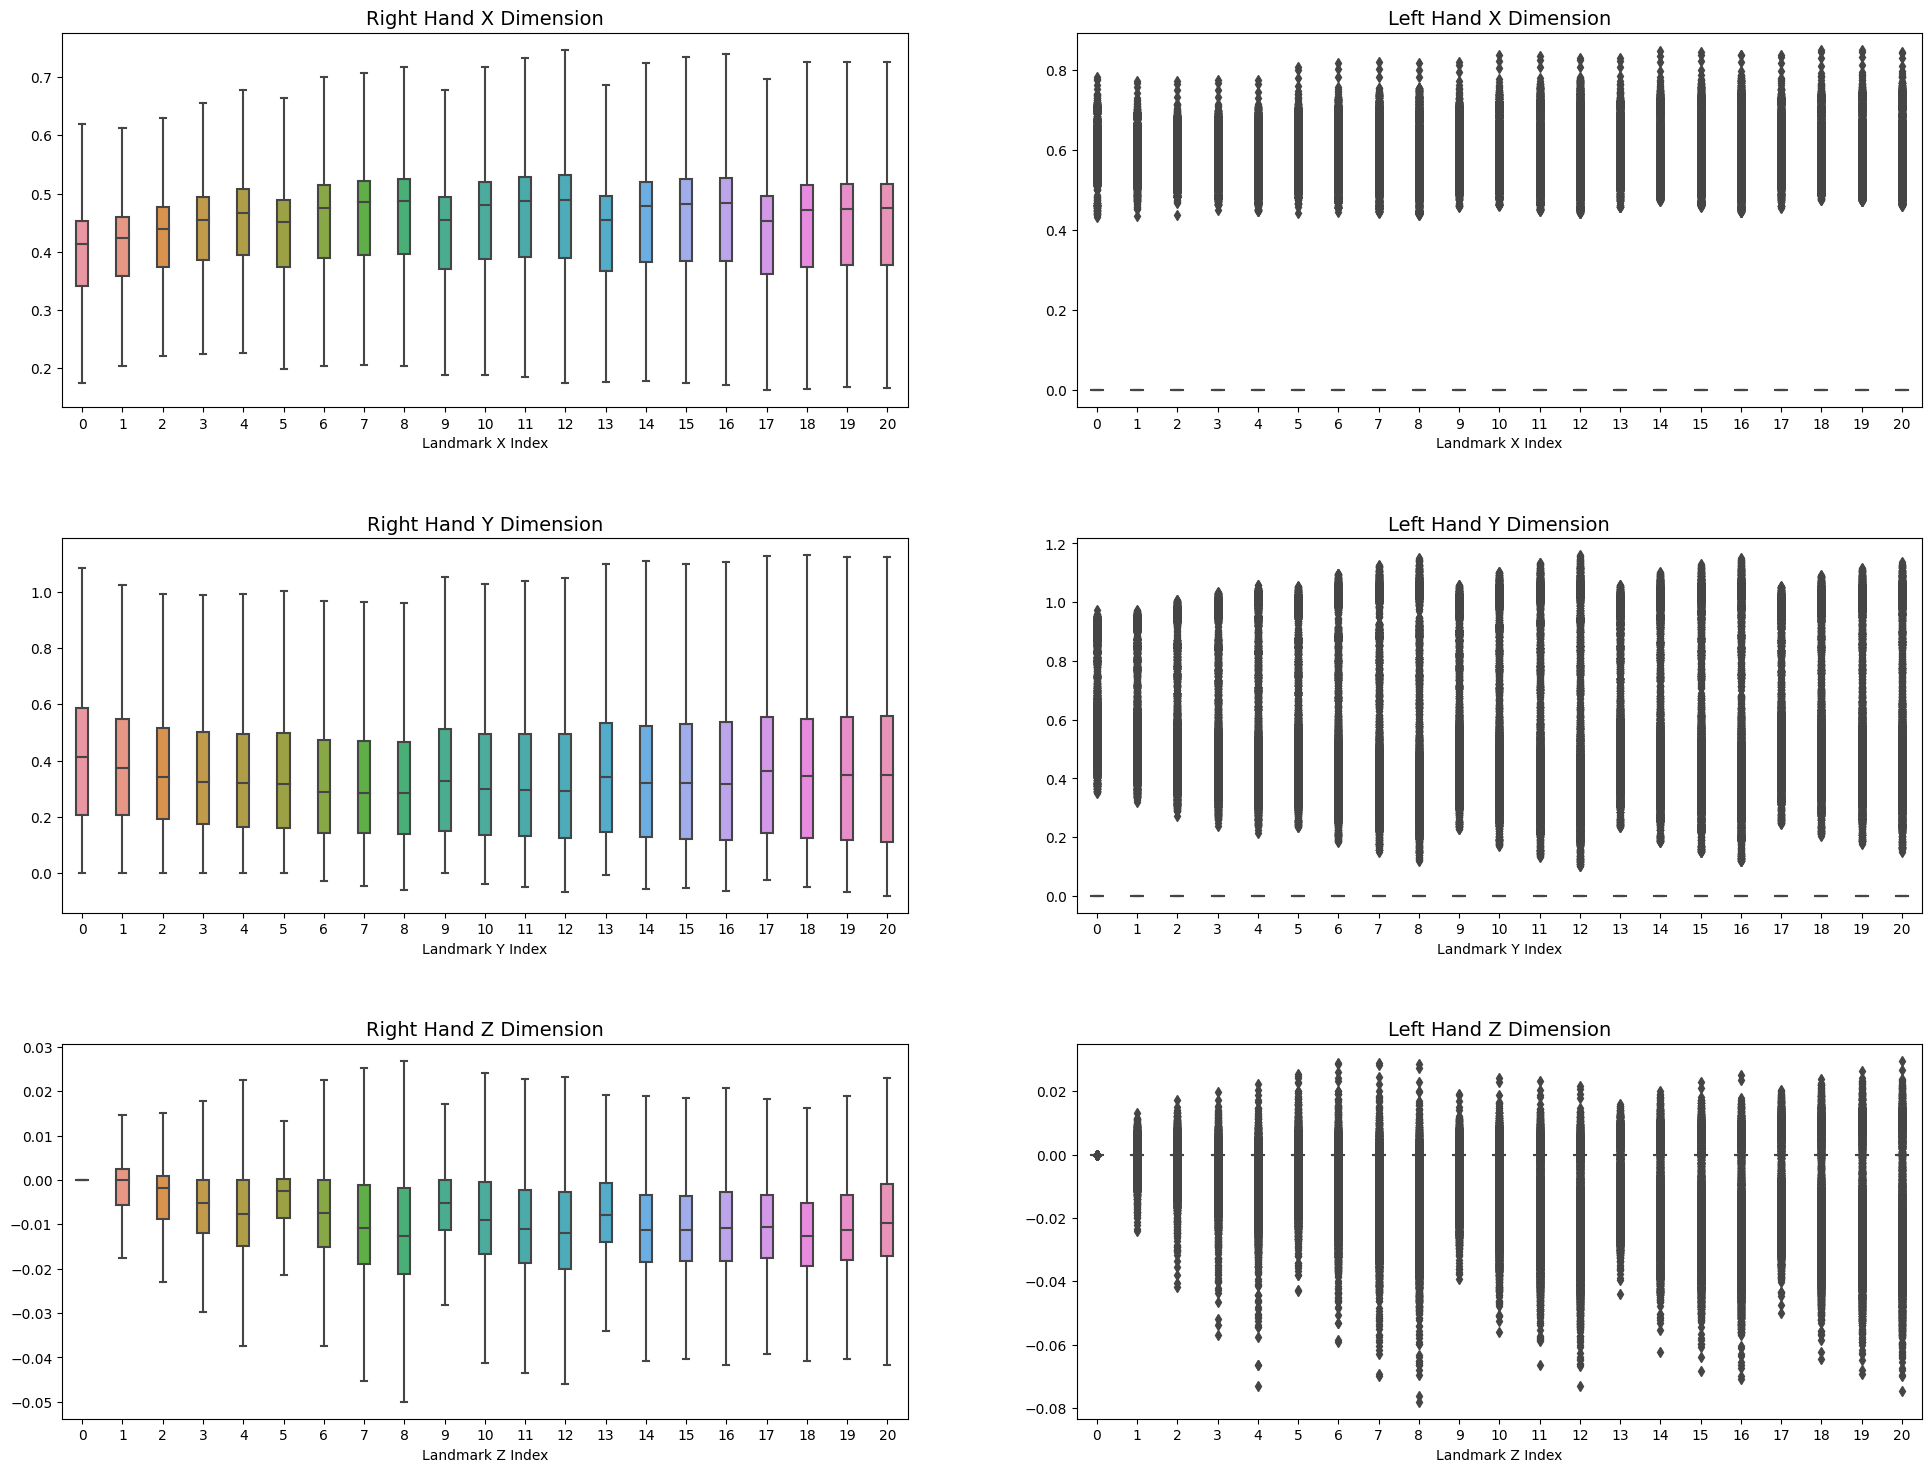

In [13]:
X1,Y1,Z1 = get_landmark_dimension(df_expanded,'right_hand')
X2,Y2,Z2 = get_landmark_dimension(df_expanded,'left_hand')

fig, ax = plt.subplots(3,2,figsize =(24, 18))
plt.subplots_adjust(hspace=.35)

sns.boxplot(ax=ax[0,0], data=X1, width=.3, showfliers=False)
ax[0,0].set_title('Right Hand X Dimension', fontsize=14)
ax[0,0].set_xlabel('Landmark X Index')

sns.boxplot(ax=ax[1,0], data=Y1, width=.3, showfliers=False)
ax[1,0].set_title('Right Hand Y Dimension', fontsize=14)
ax[1,0].set_xlabel('Landmark Y Index')

sns.boxplot(ax=ax[2,0], data=Z1, width=.3, showfliers=False)
ax[2,0].set_title('Right Hand Z Dimension', fontsize=14)
ax[2,0].set_xlabel('Landmark Z Index')

sns.boxplot(ax=ax[0,1], data=X2, width=.3, showfliers=True)
ax[0,1].set_title('Left Hand X Dimension', fontsize=14)
ax[0,1].set_xlabel('Landmark X Index')

sns.boxplot(ax=ax[1,1], data=Y2, width=.3, showfliers=True)
ax[1,1].set_title('Left Hand Y Dimension', fontsize=14)
ax[1,1].set_xlabel('Landmark Y Index')

sns.boxplot(ax=ax[2,1], data=Z2, width=.3, showfliers=True)
ax[2,1].set_title('Left Hand Z Dimension', fontsize=14)
ax[2,1].set_xlabel('Landmark Z Index')

plt.show()